In [1]:
%load_ext autoreload
%autoreload 2

In [164]:
from pathlib import Path
import tifffile
import motionquant as mq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# list files from the src folder
src = Path('/media/cephfs2/jparham/Joe for Jerome /')
filelist = pd.read_csv('filelist.csv')
#src = Path('/media/cephfs2/jparham/For Jerome/Divisions with G2toConstriction/')
dst = Path('./')

# filelist = pd.DataFrame.from_records(
#     [{'path':f,'name':f.stem} for f in src.glob('[!.]*.tif')]
# )
# filelist.head()

filename = filelist['path'].iloc[50]
print(filename)
img = tifffile.imread(filename)
pimg = mq.preprocess(img, 100)
#mask, position = mq.segment_and_track(pimg)
cell_mask, cell_trj = mq.segment_and_track_cell(pimg)
print(cell_mask.shape)

/media/cephfs2/jparham/Joe for Jerome /Divisions with G2toConstriction/01a_DSM639_SyS_CM_Cell_2.tif
(600, 1, 45, 45)


In [144]:
filelist[filelist['name'] == '01a_DSM639_SyS_CM_Cell_9.tif']

,Unnamed: 0,path,name,condition
57,57,/media/cephfs2/jparham/Joe for Jerome /Divisio...,01a_DSM639_SyS_CM_Cell_9.tif,wt


In [135]:
filename

PosixPath('/media/cephfs2/jparham/For Jerome/Divisions with G2toConstriction/01a_DSM639_SyS_CM_Cell_11.tif')

In [ ]:
for t in range(0,300,50):
    plt.imshow(30*labels[t,0] + img[t,0])
    plt.show()


Motion analysis

In [49]:
diff = mq.frame_differences(pimg[:,1])
flow = mq.compute_flow(pimg[:,1])
rho = mq.momentum(pimg[:-1,1], flow)
div = mq.divergence(rho)
print(diff.shape, flow.shape, rho.shape, div.shape)


(458, 1, 47, 47) (458, 2, 47, 47) (458, 2, 47, 47) (458, 1, 47, 47)


In [51]:
cell_mask.shape

(459, 2, 47, 47)

In [298]:
blob_labels, blob_trj = mq.segment_and_track_dna_blobs(pimg[:,1], cell_mask)

          count
particle       
1           484
0           156
{1: 1, 0: 2}


1 484
2 156


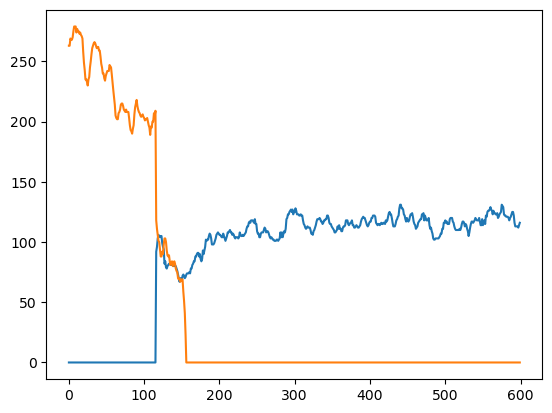

In [299]:
import numpy as np
for k in range(1,1+int(blob_labels.max())):
    y = (blob_labels==k).sum(axis=(1,2))
    print(k,np.sum(y>0))
    plt.plot(y)


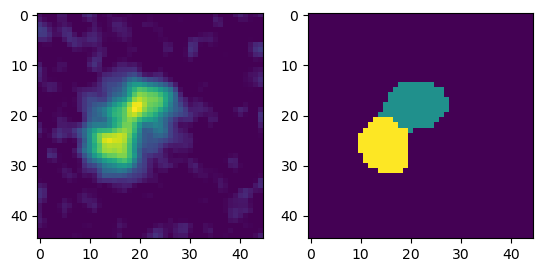

In [301]:
plt.subplot(121)
plt.imshow(pimg[125,1])
plt.subplot(122)
plt.imshow(blob_labels[125])
# from scipy import ndimage as ndi
# plt.imshow(ndi.gaussian_filter(ndi.distance_transform_edt(blob_labels[115]),2))
# d = ndi.gaussian_filter(ndi.distance_transform_edt(blob_labels[115]),2)
# plt.imshow(d==ndi.maximum_filter(d,5))

In [134]:
blob_labels.max()

2.0

In [56]:
mq.save_result("tmp.h5","tmp",img,cell_mask,cell_trj,diff,flow,rho,div,blob_labels,blob_trj)

In [ ]:
pd.read_hdf("tmp.h5","tmp/")

In [68]:
mq.inspect_result("tmp.h5")

['tmp']

In [70]:
img, cell_mask, cell_trj, diff, flow, rho, div, blob_labels, blob_trj = mq.load_result("tmp.h5","tmp")

In [125]:
df = mq.record(filename, img, cell_mask, cell_trj, diff, flow, rho, div, blob_labels, blob_trj)

In [127]:
df

,filename,frame,cell-x,cell-y,cell-area,diff,flow,momentum,divergence,dna mean intensity,dna blob count,dna blob area,dna blob 1 sum intensity,dna blob 2 sum intensity
0,/media/cephfs2/jparham/For Jerome/Divisions wi...,0,23.115453,19.726465,563.0,0.003315,0.321202,0.991957,0.014952,102.632327,1,172,18270,0
1,/media/cephfs2/jparham/For Jerome/Divisions wi...,1,23.119643,19.792857,560.0,0.100472,0.546515,1.582857,0.028348,102.491071,1,171,18108,0
2,/media/cephfs2/jparham/For Jerome/Divisions wi...,2,23.111511,19.929856,556.0,0.058791,0.371621,0.977386,0.011656,102.753597,1,174,18426,0
3,/media/cephfs2/jparham/For Jerome/Divisions wi...,3,23.128159,20.009025,554.0,-0.000679,0.225626,0.656095,-0.002365,102.981949,1,187,19888,0
4,/media/cephfs2/jparham/For Jerome/Divisions wi...,4,23.161580,20.014363,557.0,-0.095538,0.262810,0.891222,-0.009931,102.833034,1,185,19599,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,/media/cephfs2/jparham/For Jerome/Divisions wi...,453,35.608563,24.623853,327.0,-0.024853,0.282780,0.348048,0.007917,101.366972,1,69,7158,0
454,/media/cephfs2/jparham/For Jerome/Divisions wi...,454,35.493865,24.748466,326.0,0.004262,0.183378,0.221274,0.004832,101.309816,1,72,7478,0
455,/media/cephfs2/jparham/For Jerome/Divisions wi...,455,35.455385,24.836923,325.0,0.028461,0.214862,0.208301,0.000866,101.544615,1,72,7448,0
456,/media/cephfs2/jparham/For Jerome/Divisions wi...,456,35.555556,24.916667,324.0,0.056117,0.363343,0.465690,-0.003673,101.336420,1,70,7244,0


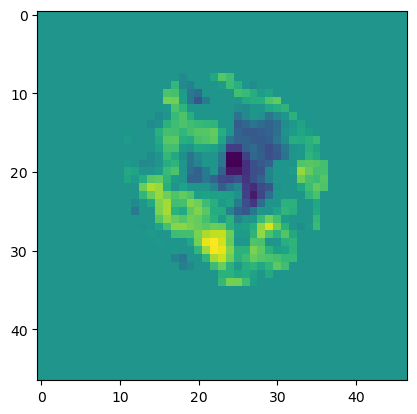

In [98]:
plt.imshow(diff[10,0]*cell_mask[10,0])

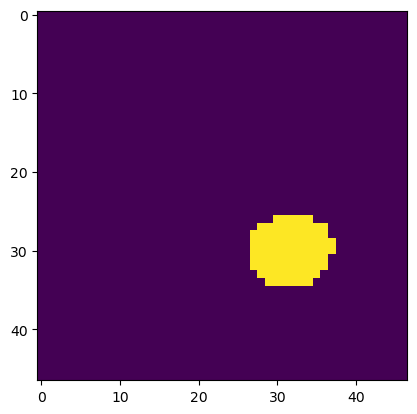

In [115]:
plt.imshow(blob_labels[200]==1)

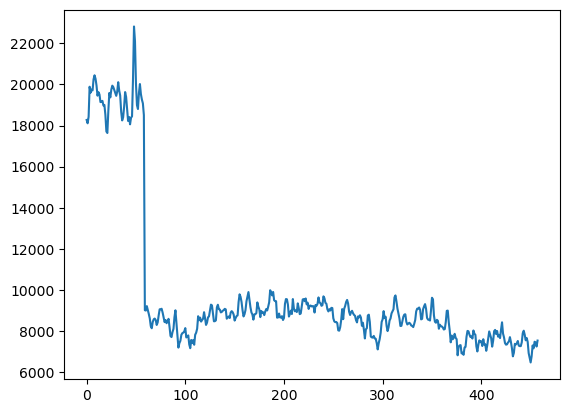

In [129]:
plt.plot(df["frame"],df["dna blob 1 sum intensity"])

In [74]:
blob_trj['particle'].unique()

array([0, 1])

In [ ]:
count, area, asymmetry_area, intensity, asymmetry_int, tmp = mq.blob_area_num_asymmetry(pimg[:,1], mask)

fig,ax = plt.subplots(5,1)
ax[0].plot(count)
ax[1].plot(area)
ax[2].plot(asymmetry_area)
ax[3].plot(intensity)
ax[4].plot(asymmetry_int)

In [ ]:
t = 100
plt.imshow(mask[t,0]+2*tmp[t] + pimg[t,1])

In [ ]:
import matplotlib.pyplot as plt
from skimage import measure

plt.imshow(mq.uv2rgb(img[300]))
for c in measure.find_contours(mask[0, 0], 0.5):
        plt.plot(c[:, 1], c[:, 0], "w")
plt.plot(position[2:,1], position[2:,0])

In [ ]:
fig, ax = plt.subplots(1,6, figsize=(15,5))
mq.figure(ax,"vv",img, mask, position, speed, diff, flow, rho, div)

In [ ]:
mq.strip(filename.stem, img, mask, position, speed, diff, flow, rho, div, "Greys", step=20, quiver=False)
plt.savefig('tmp.pdf')

In [ ]:
import napari
v = napari.view_image(img,channel_axis=1)
v.add_labels(mask.squeeze())
v.add_points(position,ndim=2)

In [ ]:
import colorsys
print(flow.max())

def vec2rgb(x):
    h = (np.arctan2(x[0],x[1])+3.1415) / (2*3.1415)
    v = np.linalg.norm(x,axis=0)    
    y = np.stack((h,v),-1).reshape(x.shape[1]*x.shape[2],2)         
    return np.stack([colorsys.hsv_to_rgb(hv[0],hv[1],1) for hv in y],0).reshape([x.shape[1],x.shape[2],3])

x,y = np.meshgrid(np.linspace(-1,1),np.linspace(-1,1))
plt.imshow(vec2rgb(np.stack((x,y))))
#plt.imshow(vec2rgb(flow[100]))
